![](logo_scanpy.svg){width=50% fig-align="center"}

세포 유형의 발달 궤적을 분석하고 시각화하는 것은 생물학 연구에서 매우 중요한 과정입니다. 특히 단일 세포 전사체 분석(single-cell transcriptomics)의 발전으로, 개별 세포의 발달 경로와 상태 변화를 더 정밀하게 추적할 수 있게 되었습니다. 이러한 분석을 위해 다양한 기법들이 사용되는데, 그 중에서도 PAGA(Partition-based Graph Abstraction)는 매우 유용한 도구로 자리 잡고 있습니다.

# 들어가며

이 글은 PAGA [튜토리얼](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)을 일부 수정한 것입니다. PAGA는 세포 간의 관계를 그래프 형태로 추상화하여, 전체 발달 경로를 파악하고 중요한 분기점들을 식별하는 데 도움을 줍니다. 이 기법은 세포 데이터를 그래프 기반으로 표현하고, 이를 통해 세포 간의 전이 상태와 경로를 시각적으로 명확하게 보여줍니다. 특히 PAGA는 복잡한 세포 상태 전이를 간단한 그래프 구조로 표현함으로써, 연구자들이 세포 발달 궤적을 더 쉽게 이해하고 분석할 수 있게 해줍니다.

# 필요한 라이브러리 불러오기

In [65]:
import os
import urllib.request
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

# 경고 무시하기
warnings.filterwarnings("ignore")
sc.settings.n_jobs = -1
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)
sc.settings.set_figure_params(
    dpi=60, frameon=False, figsize=(4, 4), facecolor="white", color_map="viridis_r"
)
print(f"사용한 SCANPY 버전: {sc.__version__}")

사용한 SCANPY 버전: 1.10.1


# 데이터 준비

연습할 데이터는 `Seurat`을 사용해 전처리된 마우스의 골수 세포 데이터입니다. 데이터 전처리에 자세한 정보는 다음 [스크립트](https://github.com/NBISweden/workshop-scRNAseq/blob/master/scripts/data_processing/slingshot_preprocessing.Rmd)에서 확인할 수 있습니다. 골수는 성인 면역 세포의 원천이며 혈액을 통해 순환되는 면역 세포의 거의 모든 분화 단계의 세포들이 포함되어 있습니다. 다음 명령을 사용하여 데이터를 다운로드합니다. 

In [66]:
# 누락되거나 계산 시간이 오래 걸리는 경우 미리 계산된 데이터 다운로드
fetch_data = True

# 예제 데이터 URL
path_data = "https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq"

path_results = "./input/trajectory"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "./input/trajectory/trajectory_seurat_filtered.h5ad"
if not os.path.exists(path_file):
    file_url = os.path.join(path_data, "trajectory/trajectory_seurat_filtered.h5ad")
    urllib.request.urlretrieve(file_url, path_file)

## 데이터 불러오기

다운로드한 `trajectory_seurat_filtered.h5ad`파일을 불러옵니다. 

In [67]:
adata = sc.read_h5ad("./input/trajectory/trajectory_seurat_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 5828 × 3585
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batches', 'dataset', 'nCount', 'nUMI', 'pMito', 'pRibo', 'pHb', 'pChY', 'pChX', 'pnonXY', 'pPCG', 'pNCG', 'pMito_UMIs', 'pRibo_UMIs', 'pHb_UMIs', 'pChY_UMIs', 'pChX_UMIs', 'pnonXY_UMIs', 'pPCG_UMIs', 'pNCG_UMIs', 'SEL_nCount', 'SEL_nUMI', 'SEL_pMito', 'SEL_pRibo', 'SEL_pHb', 'SEL_pChY', 'SEL_pChX', 'SEL_pnonXY', 'SEL_pPCG', 'SEL_pNCG', 'SEL_pMito_UMIs', 'SEL_pRibo_UMIs', 'SEL_pHb_UMIs', 'SEL_pChY_UMIs', 'SEL_pChX_UMIs', 'SEL_pnonXY_UMIs', 'SEL_pPCG_UMIs', 'SEL_pNCG_UMIs', 'S.Score', 'G2M.Score', 'Phase', 'metadata_clusters', 'clusters', 'outlier', 'subgroups', 'clusters_use'
    var: 'features'
    obsm: 'X_harmony', 'X_harmony_Phase', 'X_pca', 'X_umap', 'X_umap3d'
    varm: 'PCs'

위 출력을 통해 `adata`파일에 유맵과 클러스터 정보가 들어 있다는 것을 확인 할 수 있습니다. 이 정보를 다시 사용해도 되지만 여기서는 `scanpy`를 사용해 다시 분석할 예정입니다.

In [68]:
# X 행렬에 로그 정규화된 카운트값이 들어있는지 확인합니다.
print(adata.X[:5, :5])

  (0, 4)	0.11622072805743532
  (2, 1)	0.09413397843954842
  (3, 1)	0.08438841021254412
  (3, 4)	0.08438841021254412
  (4, 1)	0.14198147850903975


## 데이터 탐색하기

UMAP 플랏을 그려서 간단하게 살펴봅니다.

데이터 집합을 분석할 때는 무슨 일이 일어나고 있는지, 데이터에서 보이는 클러스터는 무엇이며, 가장 중요한 것은 클러스터가 서로 어떻게 연관되어 있는지 이해하는 것이 중요합니다. 그럼, 데이터를 조금 살펴봅시다. 이 표의 도움을 받아 데이터 집합에서 이러한 핵심 마커를 나타내는 클러스터 번호를 적어 보세요.


## 다시 UMAP 그리기

`Scanpy`를 사용해 클러스터링과 유맵을 다시 실행합니다. 데이터에 이미 포함된 차원감소 데이터인 `X_harmony_Phase`를 시작점으로 UMAP을 새로 그립니다.

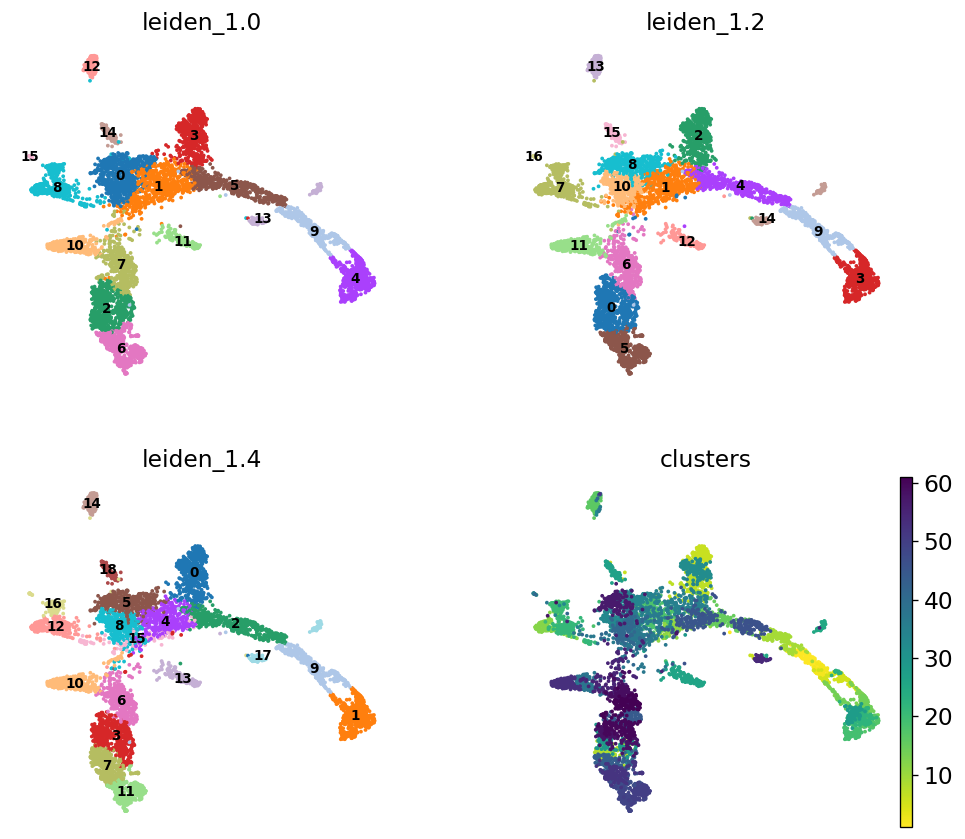

In [69]:
# 먼저 기존에 들어있던 umap 정보를 다른 이름으로 저장합니다.
adata.obsm["X_umap_old"] = adata.obsm["X_umap"]

sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20, use_rep="X_harmony_Phase")
sc.tl.umap(adata, min_dist=0.4, spread=3)
# sc.tl.umap(adata, min_dist=0.6, spread=1.5)
# sc.pl.umap(
#     adata,
#     color=["clusters"],
#     legend_loc="on data",
#     legend_fontsize="small",
#     edges=True,
# )

# 다시 클러스터링 하기
sc.tl.leiden(adata, key_added="leiden_1.0", resolution=1.0)  # default resolution in 1.0
sc.tl.leiden(adata, key_added="leiden_1.2", resolution=1.2)  # default resolution in 1.0
sc.tl.leiden(adata, key_added="leiden_1.4", resolution=1.4)  # default resolution in 1.0

sc.pl.umap(
    adata,
    color=["leiden_1.0", "leiden_1.2", "leiden_1.4", "clusters"],
    legend_loc="on data",
    legend_fontsize="xx-small",
    ncols=2,
)


클러스터로 분류는 되어있지만 각각이 어떤 세포 유형인지는 알 수 없는  아래 표의 마커 유전자 정보를 가지고 세포유형을 지정하도록 하겠습니다.


Marker    |Cell Type
---------|----------------------------
Cd34      | HSC progenitor
Ms4a1     | B cell lineage
Cd3e      | T cell lineage
Ltf       | Granulocyte lineage
Cst3      | Monocyte lineage
Mcpt8    | Mast Cell lineage
Alas2     | RBC lineage
Siglech   | Dendritic cell lineage
C1qc      | Macrophage cell lineage
Pf4       | Megakaryocyte cell lineage

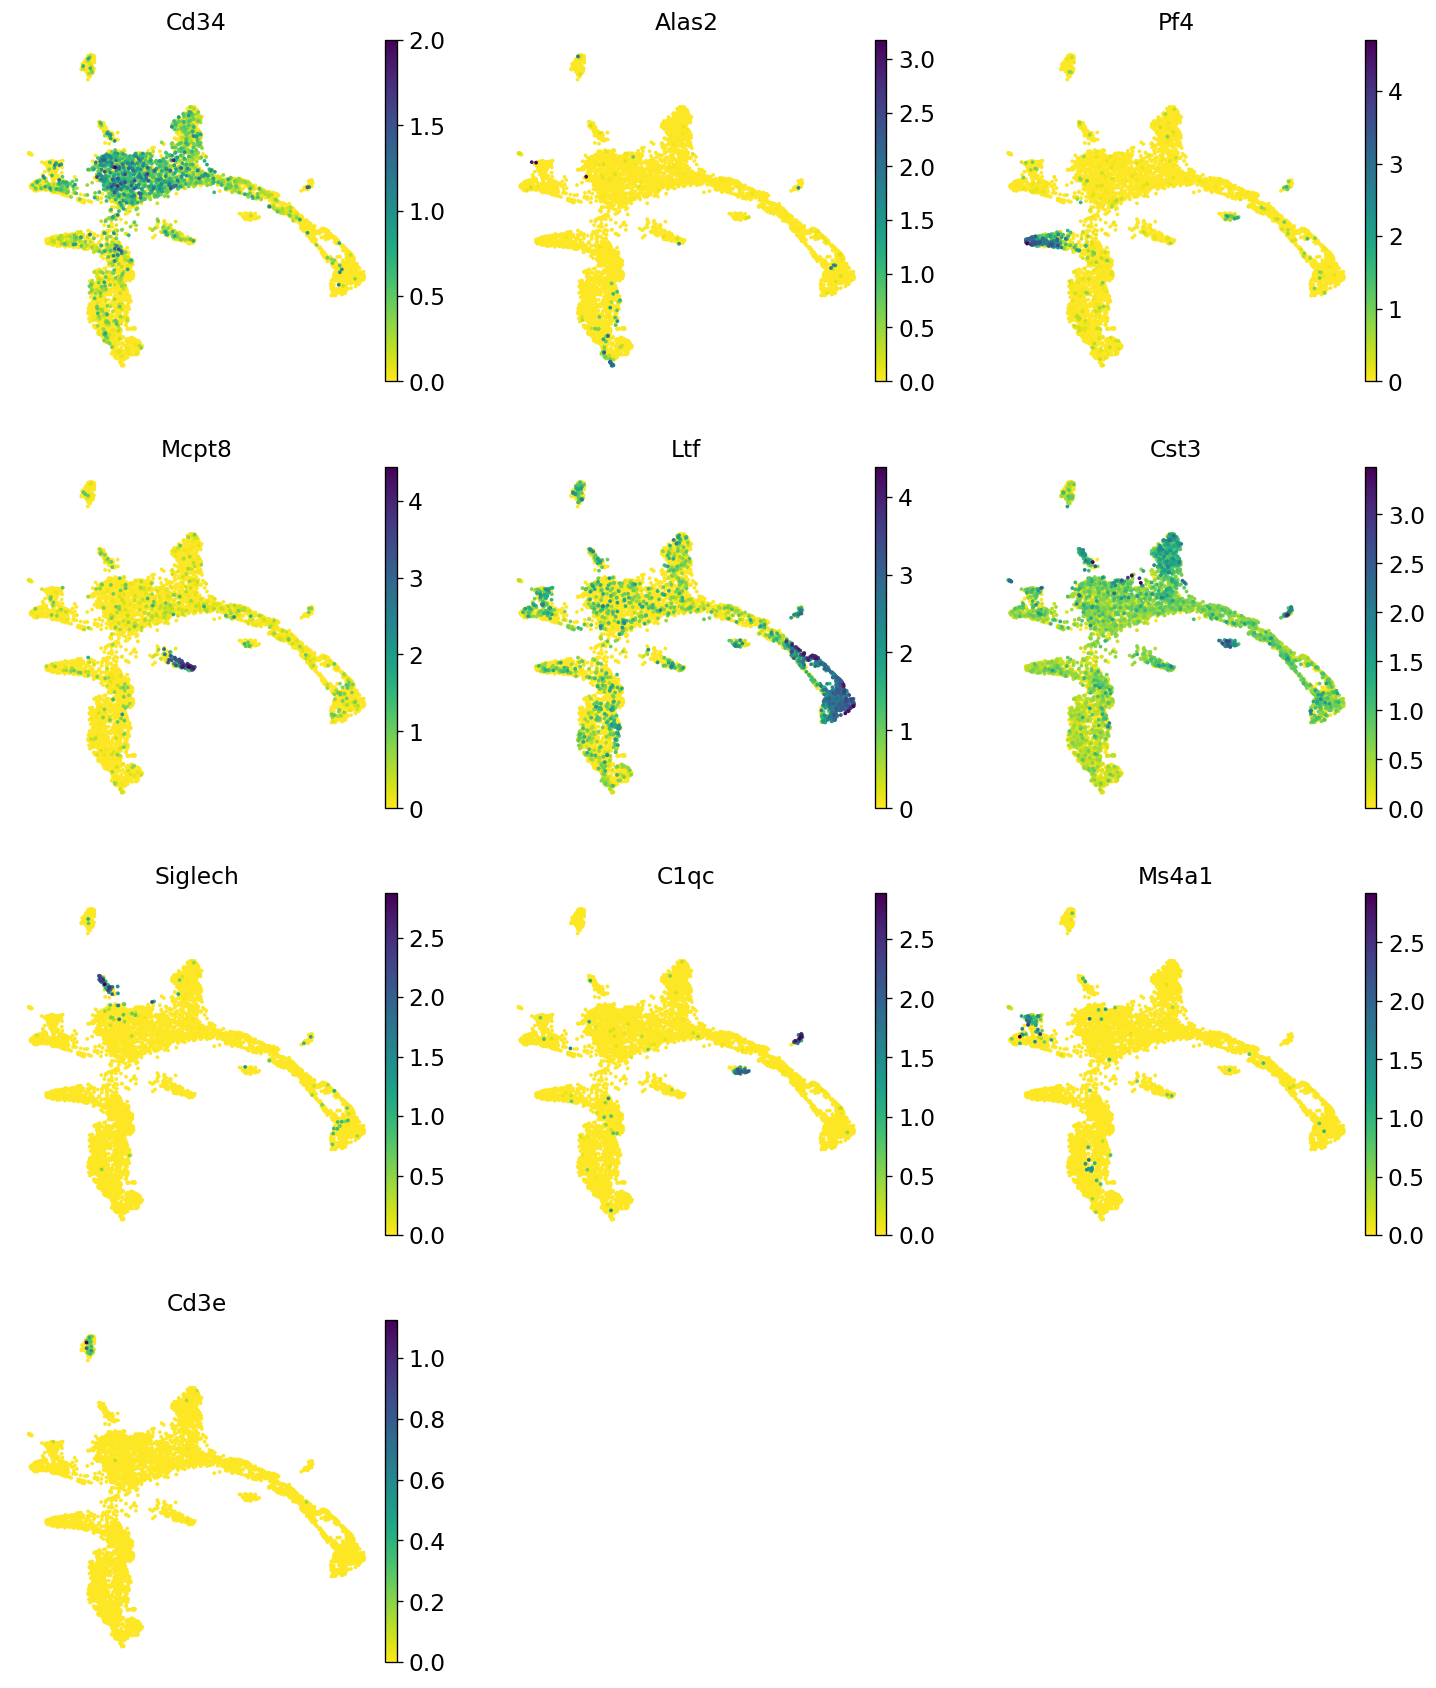

In [70]:
markers = [
    "Cd34",
    "Alas2",
    "Pf4",
    "Mcpt8",
    "Ltf",
    "Cst3",
    "Siglech",
    "C1qc",
    "Ms4a1",
    "Cd3e",
]

sc.pl.umap(adata, color=markers, use_raw=False, ncols=3)

위 시각화 결과를 참고해 `leiden_1.4` 클러스터링 결과에 세포 유형을 지정합니다.

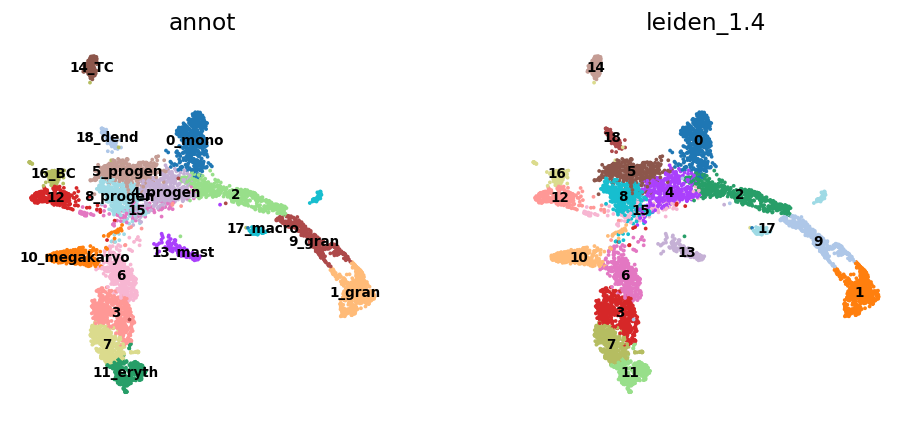

In [71]:
# 클러스터 이름 변경을 위한 매핑 딕셔너리
cluster_mapping = {
    "10": "10_megakaryo",  # Pf4
    "17": "17_macro",  # C1qc
    "11": "11_eryth",  # Alas2
    "18": "18_dend",  # Siglech
    "13": "13_mast",  # Mcpt8
    "0": "0_mono",  # Cts3
    "1": "1_gran",  # Ltf
    "9": "9_gran",  # ("1_gran"과 동일하지만 다른 클러스터)
    "14": "14_TC",  # Cd3e
    "16": "16_BC",  # Ms4a1
    "8": "8_progen",  # Cd34
    "4": "4_progen",  # (another progenitor cluster)
    "5": "5_progen",  # (another progenitor cluster)
}

# 일관성을 위해 leiden_1.4 열을 문자열로 변환하는 코드
annot = pd.DataFrame(adata.obs["leiden_1.4"].astype("string"))

# 매핑을 적용하여 클러스터 이름을 바꾸고 나머지는 변경하지 않습니다.
annot["annot"] = annot["leiden_1.4"].map(cluster_mapping).fillna(annot["leiden_1.4"])

# 새 주석으로 데이터 객체를 업데이트합니다.
adata.obs["annot"] = annot["annot"].astype("category")

# 새 주석을 사용해 UMAP 플롯하기
sc.pl.umap(
    adata,
    color=["annot", "leiden_1.4"],
    legend_loc="on data",
    ncols=2,
    legend_fontsize="xx-small",
)
# 어노테이션의 값 개수를 표시합니다.
# print(annot["annot"].value_counts())

# PAGA

`leiden_1.4` 클러스터를 사용하여 `PAGA`를 실행합니다. 먼저 그래프를 생성하고 `umap`을 사용하여 위치를 초기화합니다.

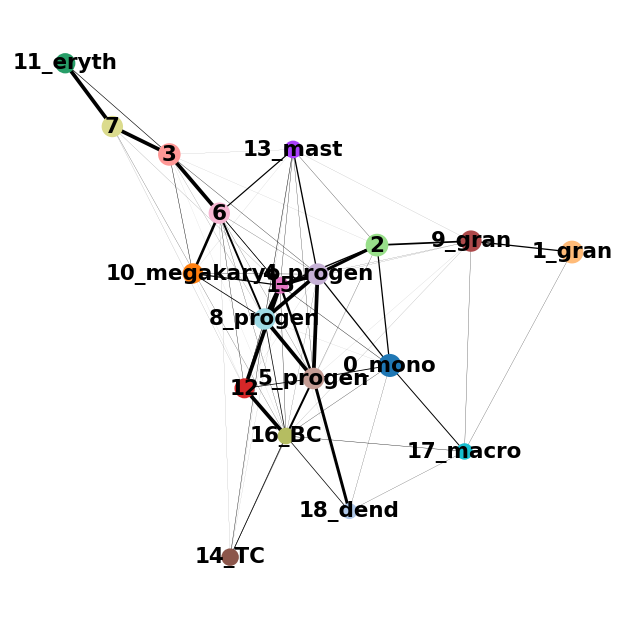

In [72]:
# umap을 사용하여 그래프 레이아웃을 초기화합니다.
sc.tl.draw_graph(adata, init_pos="X_umap")
# sc.pl.draw_graph(adata, color="annot", legend_loc="on data", legend_fontsize="xx-small")
sc.tl.paga(adata, groups="annot")

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.paga(adata, color="annot", edge_width_scale=0.3)

위 결과를 보면 서로 관련이 없는 많은 클러스터 사이에 엣지가 많이 보입니다. 따라서 데이터를 조금 더 정리해야 할 것 같네요.

## 그래프 엣지 필터링

먼저 엣지와 UMAP을 겹쳐서 좀 더 자세히 살펴봅시다.

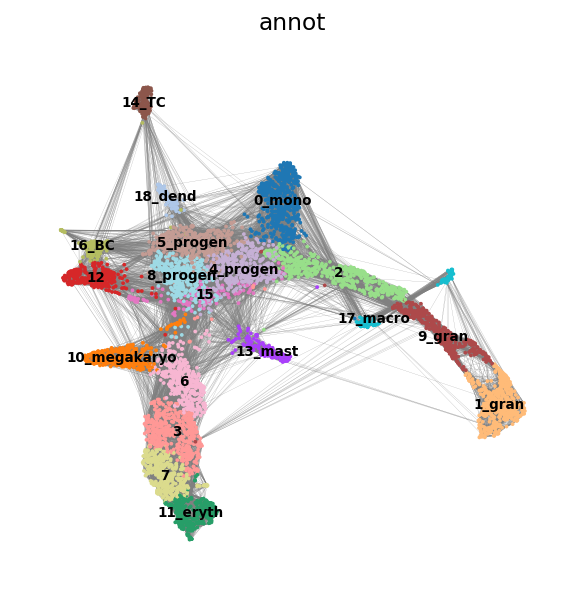

In [73]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        adata,
        edges=True,
        color="annot",
        legend_loc="on data",
        legend_fontsize="xx-small",
    )

위 그림에서 알 수 있듯이, 관련 없는 클러스터 사이의 엣지가 보입니다. 따라서 더 적은 수의 이웃(`n_neighbors=5`)로 다시 그려 보겠습니다.

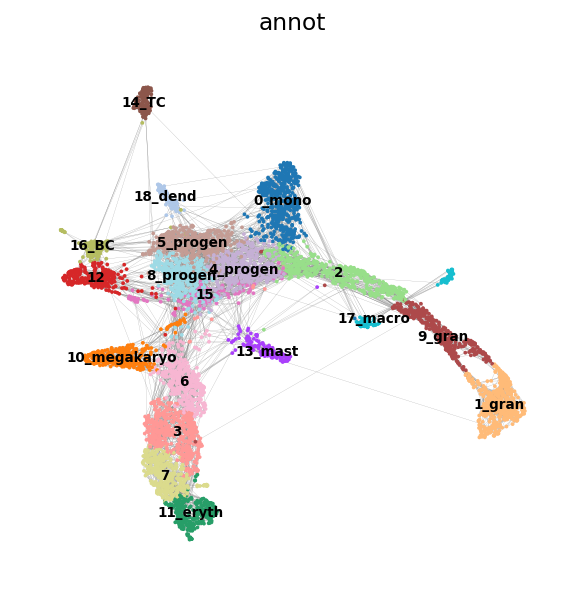

In [74]:
sc.pp.neighbors(adata, n_neighbors=5, use_rep="X_harmony_Phase", n_pcs=30)

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        adata,
        edges=True,
        color="annot",
        legend_loc="on data",
        legend_fontsize="xx-small",
    )

불필요한 그래프 엣지가 훨씬 줄어들었습니다. 이제 다시 `PAGA`를 실행합니다.

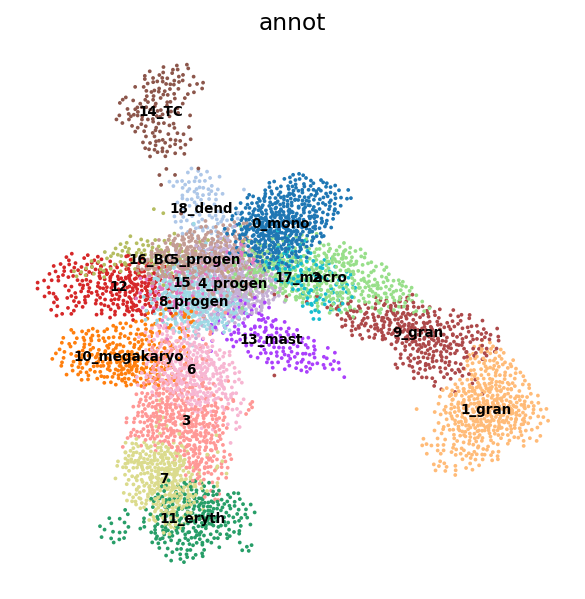

In [75]:
sc.tl.draw_graph(adata, init_pos="X_umap")

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.draw_graph(adata, color="annot", legend_loc="on data", legend_fontsize="xx-small")

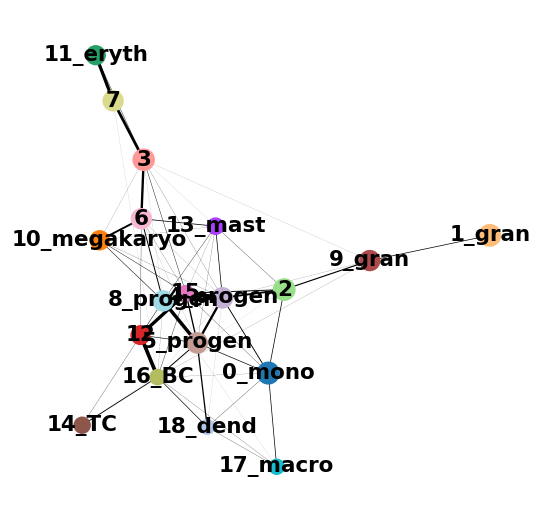

In [76]:
sc.tl.paga(adata, groups="annot")
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.paga(adata, color="annot", edge_width_scale=0.3)

## PAGA 초기화해서 임베딩하기

`PAGA` 레이아웃의 다른 시작 위치를 사용하여 그래프를 다시 그릴 수 있습니다. 다음은 UMAP에서도 가능합니다.

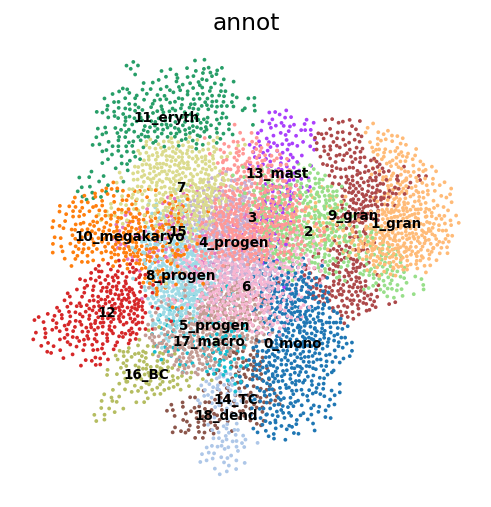

In [77]:
sc.tl.draw_graph(adata, init_pos="paga")

with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.draw_graph(adata, color=["annot"], legend_loc="on data", legend_fontsize="xx-small")

이제 모든 마커 유전자를 의미 있는 레이아웃으로 볼 수 있습니다.

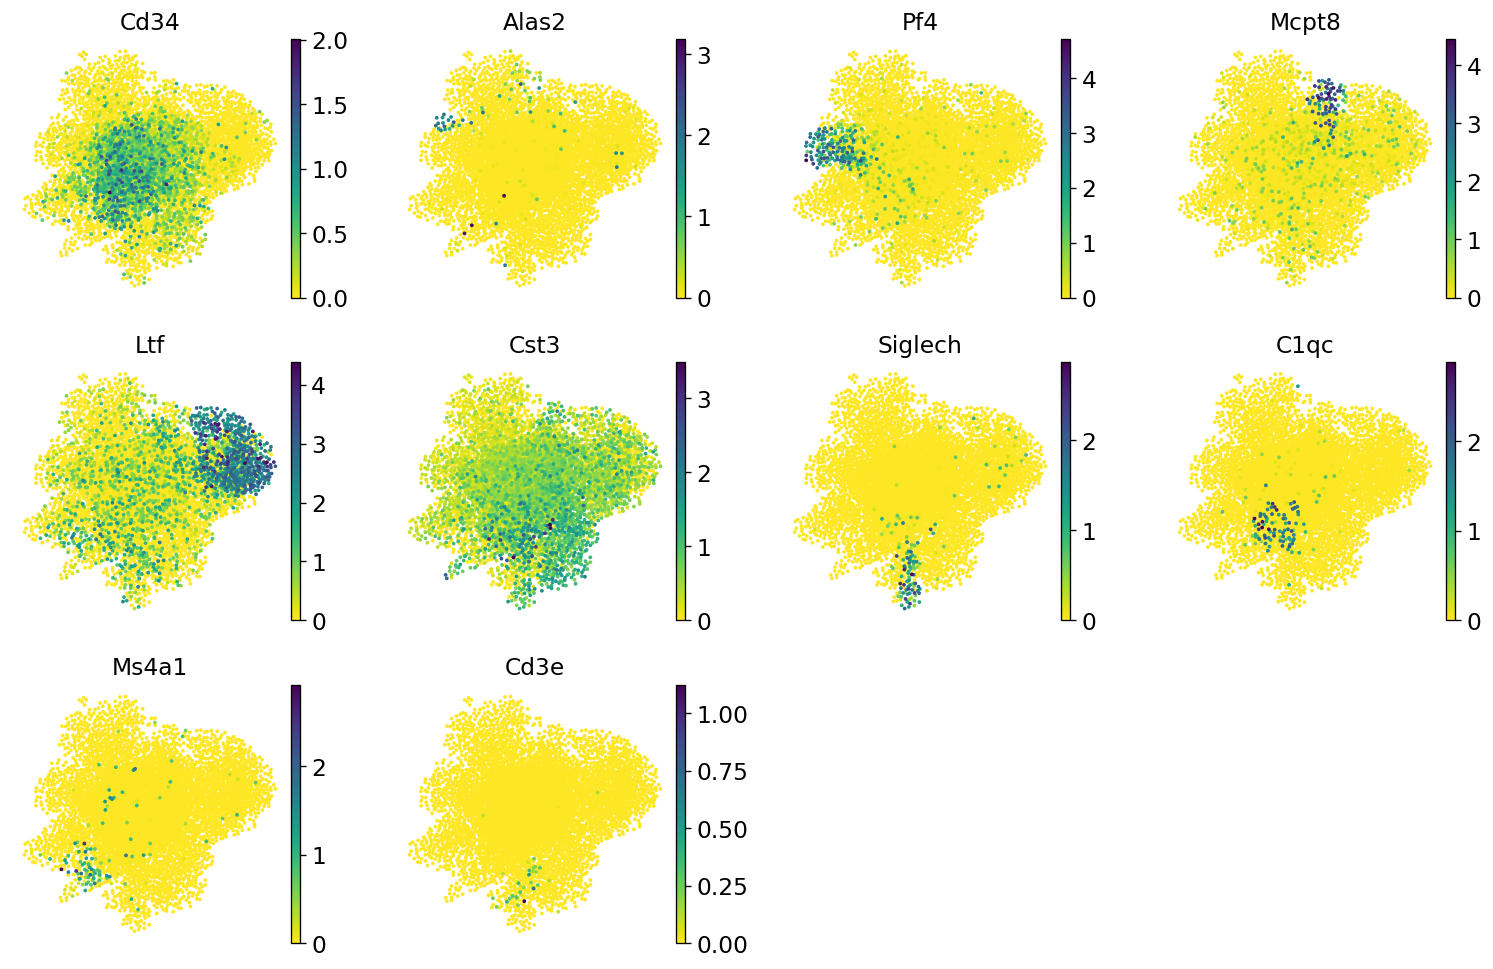

In [78]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.draw_graph(adata, color=markers, use_raw=False)

## 두 그래프 비교

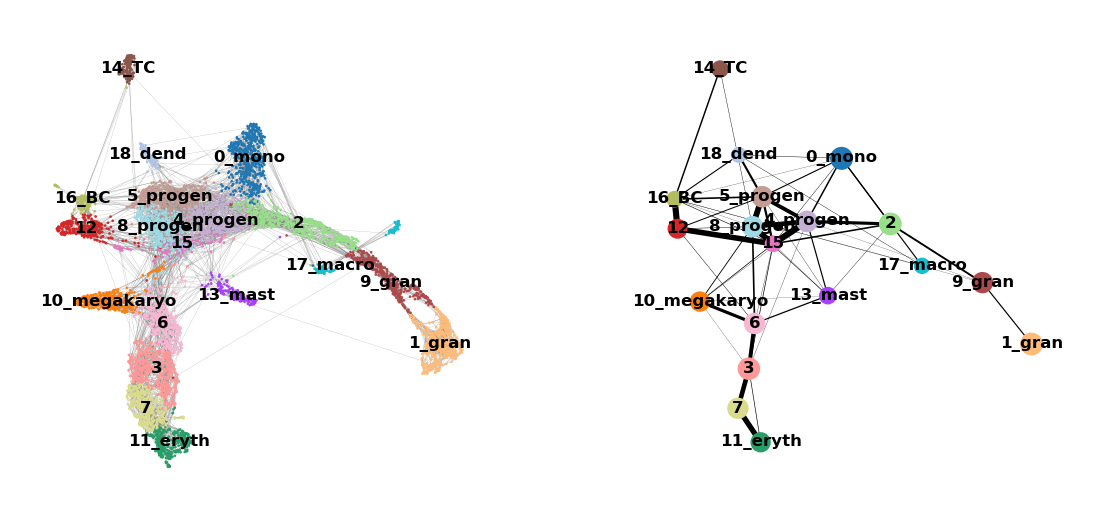

In [79]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.paga_compare(
        adata,
        threshold=0.03,
        title="",
        right_margin=0.2,
        size=10,
        edge_width_scale=0.5,
        legend_fontsize=10,
        fontsize=10,
        frameon=False,
        edges=True,
    )

# with plt.rc_context({"figure.figsize": (5, 5)}):
#     plt.show()

# 유전자 변화

`PAGA` 경로를 따라 주어진 유전자 세트에 대한 변화를 재구성할 수 있습니다. 위 데이터에 3 종류의 `progenitor`가 있지만 그 중 가장 명확해보이는 5번 클러스터를 루트로 선택합니다. 

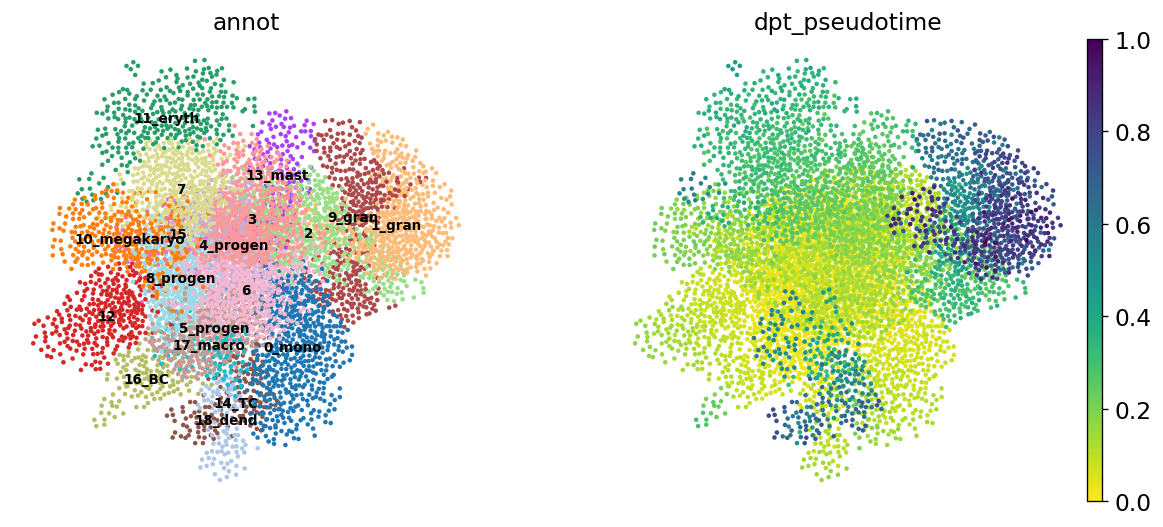

In [80]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["annot"] == "5_progen")[0]

sc.tl.dpt(adata)

with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.draw_graph(
        adata,
        color=["annot", "dpt_pseudotime"],
        legend_loc="on data",
        legend_fontsize="xx-small",
        s=30,
    )

서로 다른 알려진 계보와 그래프의 레이아웃을 살펴보고 특정 계보에 해당하는 그래프의 일부 경로를 수동으로 정의합니다.

In [81]:
# Define paths

paths = [
    ("erythrocytes", ["5_progen", "8_progen", "6", "3", "7", "11_eryth"]),
    ("lympoid", ["5_progen", "12", "16_BC", "14_TC"]),
    ("granulo", ["5_progen", "4_progen", "2", "9_gran", "1_gran"]),
    ("mono", ["5_progen", "4_progen", "0_mono", "18_dend", "17_macro"]),
]

adata.obs["distance"] = adata.obs["dpt_pseudotime"]

그런 다음 혈통에 따라 달라질 수 있는 몇 가지 유전자를 선택하고 경로에 플롯합니다.

In [82]:
gene_names = [
    "Gata2",
    "Gata1",
    "Klf1",
    "Epor",
    "Hba-a2",  # erythroid
    "Elane",
    "Cebpe",
    "Gfi1",  # neutrophil
    "Irf8",
    "Csf1r",
    "Ctsg",  # monocyte
    "Itga2b",
    "Prss34",
    "Cma1",
    "Procr",  # Megakaryo,Basophil,Mast,HPC
    "C1qc",
    "Siglech",
    "Ms4a1",
    "Cd3e",
    "Cd34",
]

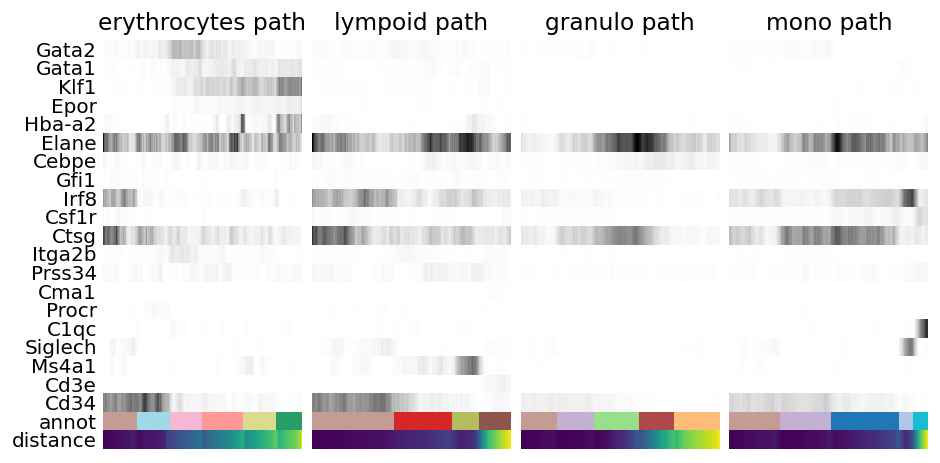

In [83]:
_, axs = plt.subplots(ncols=4, figsize=(8, 5), gridspec_kw={"wspace": 0.05, "left": 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data, *_ = sc.pl.paga_path(
        adata,
        path,
        gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["distance"],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map="Greys",
        groups_key="annot",
        color_maps_annotations={"distance": "viridis"},
        title=f"{descr} path",
        return_data=True,
        use_raw=False,
        show=False,
    )
    # 결과 저장용 코드
    # import csv
    # path_results = "./output/trajectory/"
    # if not os.path.exists(path_results):
    #     os.makedirs(path_results, exist_ok=True)
    # with open(path_results + f"paga_path_{descr}.csv", "w+") as file:
    #     writer = csv.writer(file)
    #     writer.writerow(_)

plt.show()

# 나가며

세포 유형의 발달 궤적을 분석하는 과정에서 이웃 수와 구성 요소 수와 같은 변수들을 어떻게 선택하느냐에 따라 결과가 크게 달라집니다. 그러니 이 글에서 살펴본 것처럼 데이터에 대한 사전 정보가 충분해야 실제 세포 간의 관계를 정의하고, 발달 경로를 이해하는 결과로 해석을 할 수 있습니다.

또한 여기서는`Seurat`의 `UMAP` 결과를 기반으로 `PAGA` 궤적을 생성하는 방법을 소개했는데, 이는 보다 직관적이고 정밀한 궤적 분석을 가능하게 합니다. 이런 분석 기법들은 단일 세포 전사체 데이터를 다루는 연구자들에게 매우 유용하며 데이터의 복잡성을 효과적으로 줄이면서도 중요한 생물학적 의미를 파악하는 데 도움을 줍니다. 이 글을 통해 `PAGA`를 활용한 궤적 분석의 기본 개념과 실용적인 적용 방법을 이해하는 데 도움이 되었기를 바랍니다. 세포 발달 궤적을 분석하는 과정에서의 다양한 선택지와 그 영향을 연구하면서 보다 정확하고 유의미한 결과를 도출하는 연구를 계속 이어가시기 바랍니다.